In [145]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats

This is the preliminary data analysis to create modelling assumptions, engineer new features, and find out how we can create a target to generate trading signals.

In [146]:
data=pd.read_csv('../../assets/data.csv', index_col=[0])
COLS=['DATE','CLOSE','HIGH','VOLUME','VOLATILITY_90D'] # I am only interested in the raw features

In [147]:
ID_DATA: dict[str, pd.DataFrame] = {i:data.loc[data.ID==i][COLS] for i in data.ID.unique()}

Peeking at the data, we see that the features are only available at the end of the trading day; the `HIGH` is only known when you collect all price information, `CLOSE` is the last observation of the day. Similarly, `VOLATILITY_90D` is a rolling calculation of returns so that information is also only known at the end of the trading day.

So **Assumption #1** will be that all the trading decisions we make can only be done at the end of the trading day because the raw features we have can only be observed at (daily) market close. The same goes for any engineered features because they are based on the raw features for any calculation. So any trades done on intra-day information will be look-ahead bias.

In [148]:
ID_DATA['AAPL']

,DATE,CLOSE,HIGH,VOLUME,VOLATILITY_90D
55023,2010-08-31,8.682,8.734,420786408,116.917
55010,2010-09-01,8.940,8.981,697035220,116.117
54993,2010-09-02,9.006,9.006,415425192,115.003
54978,2010-09-03,9.242,9.242,520788268,113.779
54972,2010-09-07,9.208,9.269,342825252,112.786
...,...,...,...,...,...
69,2024-04-29,173.500,176.030,68169419,57.168
52,2024-04-30,170.330,174.990,65934776,57.567
41,2024-05-01,169.300,172.705,50383147,57.342
21,2024-05-02,173.030,173.415,94214915,57.342


In [149]:
tickers = {
    "Inflation_Expectation": "TIP",  # iShares TIPS Bond ETF as a proxy for inflation expectations
    "Unemployment_Proxy": "SIVR",  # Aberdeen Standard Physical Silver Shares ETF (sometimes used as economic health indicator)
    "US_Economy": "SPY",  # SPDR S&P 500 ETF as a proxy for overall US economic health
    "Govt_Debt_Proxy": "TLT",  # iShares 20+ Year Treasury Bond ETF as a proxy for government debt
    "Treasury_10Y": "^TNX",  # 10-Year Treasury Yield
    "Treasury_5Y": "^FVX",  # 5-Year Treasury Yield
    "Treasury_2Y": "^IRX",  # 2-Year Treasury Yield
    "US_Dollar": "DX-Y.NYB",  # US Dollar Index
    "Gold": "GC=F",  # Gold Futures
    "Oil": "CL=F",  # Crude Oil Futures
    "VIX": "^VIX",  # CBOE Volatility Index
    "Real_Estate": "IYR",  # iShares U.S. Real Estate ETF
    "Consumer_Sentiment": "XLY"  # Consumer Discretionary Select Sector SPDR Fund
}

In [150]:
groups = []
for indicator, ticker in tickers.items():
    try:
        data = yf.download(ticker, start="2010-01-01", end="2024-08-20")
        if not data.empty:
            data.insert(0, "ID", indicator)
            data=data.drop(['Volume', 'Adj Close'],axis=1)
            groups.append(data)
        else:
            print(f"No data available for {indicator} ({ticker})")
    except Exception as e:
        print(f"Error downloading data for {indicator} ({ticker}): {str(e)}")

macro_data = pd.concat(groups)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


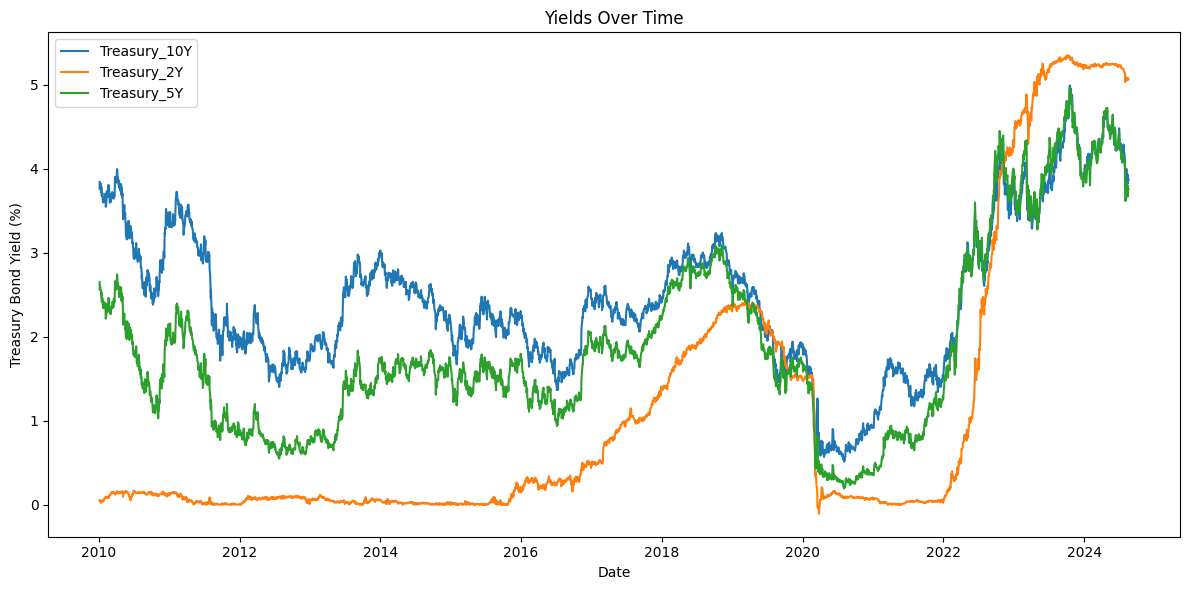

In [151]:
df_pivot = macro_data.loc[macro_data.ID.isin(['Treasury_10Y','Treasury_2Y','Treasury_5Y'])].pivot(columns='ID', values='Close')
feature1='Treasury_10Y'
feature2='Treasury_2Y'
feature3='Treasury_5Y'

plt.figure(figsize=(12, 6))
plt.plot(df_pivot.index, df_pivot[feature1], label=feature1)
plt.plot(df_pivot.index, df_pivot[feature2], label=feature2)
plt.plot(df_pivot.index, df_pivot[feature3], label=feature3)

plt.title(f"Yields Over Time")
plt.xlabel("Date")
plt.ylabel("Treasury Bond Yield (%)")
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [152]:
ID_DATA["MACRO"]=macro_data

In [153]:
market_index = "^GSPC"  # S&P 500
sector_etfs = {
    "Technology": "XLK",
    "Financial": "XLF",
    "Healthcare": "XLV",
    "Consumer_Discretionary": "XLY",
    "Consumer_Staples": "XLP",
    "Energy": "XLE",
    "Utilities": "XLU",
    "Materials": "XLB",
    "Industrial": "XLI",
    "Real_Estate": "XLRE",
    "Communication_Services": "XLC"
}

In [154]:
def download_and_calculate_returns(tickers, start_date, end_date):
    data = yf.download(list(tickers.values()) + [market_index], start=start_date, end=end_date)['Adj Close']
    returns = data.pct_change().dropna()
    return returns

def calculate_betas(returns, market_index):
    betas = {}
    market_returns = returns[market_index]
    
    for sector, ticker in sector_etfs.items():
        sector_returns = returns[ticker]
        beta, _, _, _, _ = stats.linregress(market_returns, sector_returns)
        betas[sector] = beta
    
    return pd.Series(betas)

[*********************100%%**********************]  12 of 12 completed


Sector Betas:
Technology                1.231926
Financial                 1.044105
Healthcare                0.738613
Consumer_Discretionary    1.087936
Consumer_Staples          0.599786
Energy                    1.033477
Utilities                 0.666978
Materials                 0.964229
Industrial                0.974477
Real_Estate               0.877627
Communication_Services    1.011360
dtype: float64


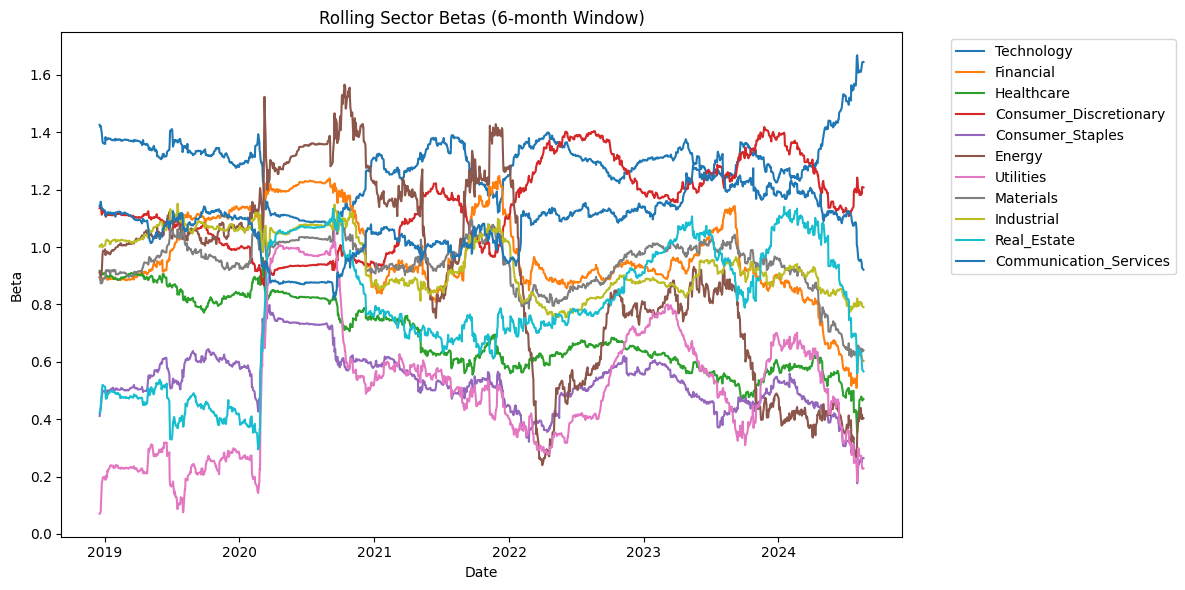

In [155]:
# Set date range
start_date = "2010-01-01"
end_date = "2024-08-20"

# Download data and calculate returns
returns = download_and_calculate_returns(sector_etfs, start_date, end_date)

# Calculate betas
sector_betas = calculate_betas(returns, market_index)

# Display sector betas
print("Sector Betas:")
print(sector_betas)

# Calculate rolling betas (e.g., 1-year rolling window)
window = 252//2  # Approximately 1 trading year
rolling_betas = pd.DataFrame(index=returns.index, columns=sector_etfs.keys())

for sector, ticker in sector_etfs.items():
    rolling_beta = returns[ticker].rolling(window=window).cov(returns[market_index]) / returns[market_index].rolling(window=window).var()
    rolling_betas[sector] = rolling_beta

plt.figure(figsize=(12, 6))
for sector in sector_etfs.keys():
    plt.plot(rolling_betas.index, rolling_betas[sector], label=sector)

plt.title("Rolling Sector Betas (6-month Window)")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [156]:
ID_DATA["STATIC_BETA"]=sector_betas
ID_DATA["BETA_6M"]=rolling_betas

In [157]:
ID_DATA.keys()

dict_keys(['AMT', 'XOM', 'T', 'SO', 'PFE', 'NVDA', 'NFLX', 'JPM', 'JNJ', 'GLD', 'MARK', 'GE', 'COST', 'AMZN', 'TSLA', 'AAPL', 'MACRO', 'STATIC_BETA', 'BETA_6M'])

In [158]:
for k,v in ID_DATA.items():
    print(v)

             DATE   CLOSE     HIGH   VOLUME  VOLATILITY_90D
55951  2010-06-02   41.45   41.510  4244815          25.906
55936  2010-06-03   42.48   42.595  3877186          26.124
55929  2010-06-04   41.51   42.310  5101243          26.415
55917  2010-06-07   41.90   42.470  5725921          26.432
55903  2010-06-08   42.25   42.620  6441412          26.466
...           ...     ...      ...      ...             ...
70     2024-04-29  174.99  175.560  2115182          22.413
53     2024-04-30  171.56  176.920  3710749          22.610
36     2024-05-01  176.84  178.810  3877575          23.105
23     2024-05-02  179.64  179.700  3278182          23.282
6      2024-05-03  181.74  184.890  3130327          23.369

[3505 rows x 5 columns]
             DATE    CLOSE    HIGH    VOLUME  VOLATILITY_90D
55948  2010-06-02   60.770   60.80  28670754          18.993
55939  2010-06-03   61.560   62.01  32385588          19.137
55919  2010-06-04   59.525   61.05  45019194          19.927
55915  2010

In [159]:
ID_DATA

{'AMT':              DATE   CLOSE     HIGH   VOLUME  VOLATILITY_90D
 55951  2010-06-02   41.45   41.510  4244815          25.906
 55936  2010-06-03   42.48   42.595  3877186          26.124
 55929  2010-06-04   41.51   42.310  5101243          26.415
 55917  2010-06-07   41.90   42.470  5725921          26.432
 55903  2010-06-08   42.25   42.620  6441412          26.466
 ...           ...     ...      ...      ...             ...
 70     2024-04-29  174.99  175.560  2115182          22.413
 53     2024-04-30  171.56  176.920  3710749          22.610
 36     2024-05-01  176.84  178.810  3877575          23.105
 23     2024-05-02  179.64  179.700  3278182          23.282
 6      2024-05-03  181.74  184.890  3130327          23.369
 
 [3505 rows x 5 columns],
 'XOM':              DATE    CLOSE    HIGH    VOLUME  VOLATILITY_90D
 55948  2010-06-02   60.770   60.80  28670754          18.993
 55939  2010-06-03   61.560   62.01  32385588          19.137
 55919  2010-06-04   59.525   61.05  450

In [167]:
start='2020-01-01'
end='2024-08-01'

for k,v in ID_DATA.items():
    print(k)
    
    if type(v) == pd.Series:
        continue

    print(v.columns.to_list())
    
    if 'DATE' in v.columns.to_list():
        v.DATE=pd.to_datetime(v.DATE)
        ID_DATA[k]=v.loc[(v.DATE > start) & (v.DATE < end)]

    elif 'Date' in v.columns.to_list():
        v.Date=pd.to_datetime(v.Date)
        ID_DATA[k]=v.loc[(v.Date > start) & (v.Date < end)]

    else:
        print('no date col found')

AMT
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
XOM
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
T
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
SO
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
PFE
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
NVDA
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
NFLX
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
JPM
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
JNJ
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
GLD
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
MARK
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
GE
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
COST
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
AMZN
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
TSLA
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
AAPL
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
MACRO
['index', 'Date', 'ID', 'Open', 'High', 'Low', 'Close']
BETA_6M

/var/folders/zj/h0kz7p216vg8wfpn043t_y5w0000gn/T/ipykernel_8046/3272951475.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v.DATE=pd.to_datetime(v.DATE)


In [168]:
def merge_stock_dataframes(data_dict):
    merged_dfs = []
    
    for ticker, df in data_dict.items():
        # Make a copy of the DataFrame to avoid modifying the original
        df_copy = df.copy()
        
        # Identify the date column (case-insensitive)
        date_col = next((col for col in df_copy.columns if col.lower() == 'date'), None)
        
        if date_col is None:
            raise ValueError(f"No 'Date' or 'DATE' column found in DataFrame for {ticker}")
        
        # Ensure the date column is named consistently
        df_copy.rename(columns={date_col: 'Date'}, inplace=True)
        
        # Set the Date as index if it's not already
        if 'Date' in df_copy.columns:
            df_copy.set_index('Date', inplace=True)
        
        # Add a 'Ticker' column
        df_copy['Ticker'] = ticker
        
        # Append to the list of DataFrames
        merged_dfs.append(df_copy)
    
    # Concatenate all DataFrames
    result = pd.concat(merged_dfs, axis=0)
    
    # Ensure the index is datetime type
    result.index = pd.to_datetime(result.index)
    
    # Sort the DataFrame by Date and then by Ticker
    result.sort_index(level=['Date', 'Ticker'], inplace=True)
    
    return result


In [164]:
ID_DATA['MACRO'].reset_index(inplace=True)

In [165]:
ID_DATA['BETA_6M'].reset_index(inplace=True)

In [166]:
static_beta=ID_DATA['STATIC_BETA']
del ID_DATA['STATIC_BETA']

In [169]:
df=merge_stock_dataframes(ID_DATA)

In [170]:
df

,CLOSE,HIGH,VOLUME,VOLATILITY_90D,Ticker,index,ID,Open,High,Low,...,Financial,Healthcare,Consumer_Discretionary,Consumer_Staples,Energy,Utilities,Materials,Industrial,Real_Estate,Communication_Services
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,228.5000,231.1500,1425971.0,23.300,AMT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,MACRO,46678.0,Consumer_Sentiment,126.209999,126.910004,125.720001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,MACRO,42997.0,Real_Estate,93.440002,93.540001,91.599998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,29.3306,29.6023,30256306.0,17.771,T,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,MACRO,39316.0,VIX,13.460000,13.720000,12.420000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31,NaN,NaN,NaN,NaN,MACRO,22068.0,Treasury_5Y,4.019000,4.047000,3.993000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-31,NaN,NaN,NaN,NaN,MACRO,47829.0,Consumer_Sentiment,186.839996,189.059998,186.429993,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-31,NaN,NaN,NaN,NaN,MACRO,18389.0,Treasury_10Y,4.128000,4.134000,4.091000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Date'>

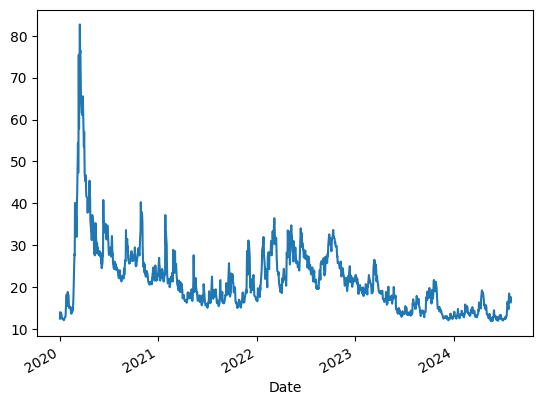

In [171]:
df.loc[(df.Ticker=='MACRO') & (df.ID=='VIX')].Close.plot()

In [172]:
df.to_csv('../../assets/macro_included.csv')